In [1]:
from pathlib import Path
from tqdm import tqdm
import os
import json
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import pickle
with open("./net_ana.p", "rb") as f:
    net_ana = pickle.load(f)

loss = net_ana["loss"]
acc = net_ana["acc"]
fc1s = net_ana["neuron"]
d = net_ana["d"]
width = net_ana["width"]
Delta = net_ana["Delta"]
T = net_ana["T"]
p = 4

In [3]:
x_po = np.random.randn(d)
x_po[0] = np.sin(Delta)
x_po[1] = -np.cos(Delta)
x_po[2:] = 0.0

x_ne = np.random.randn(d)
x_ne[0] = -np.sin(Delta)
x_ne[1] = -np.cos(Delta)
x_ne[2:] = 0.0


x_po_perp_dir = x_ne - np.dot(x_po, x_ne) * x_po
x_po_perp = x_po_perp_dir / np.linalg.norm(x_po_perp_dir)


x_ne_perp_dir = x_po - np.dot(x_ne, x_po) * x_ne
x_ne_perp = x_ne_perp_dir / np.linalg.norm(x_ne_perp_dir)

mu_dir = p * x_po - x_ne
mu = mu_dir / np.linalg.norm(mu_dir)

/Users/wangmingze/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


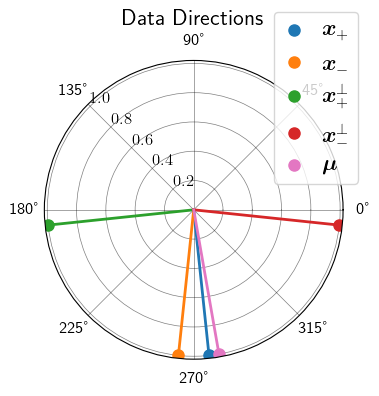

In [4]:
from matplotlib import rcParams
plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{amsmath}",
    "font.family": "sans-serif",
#     "font.serif": ["Calibri"abs],
    "grid.color": "0.5",    # gray gridlines
    "grid.linestyle": "-",  # solid gridlines
    "grid.linewidth": 0.5,  # thin gridlines
    "axes.titlesize" : 16,
    "axes.labelsize" : 12,
    "lines.linewidth" : 3,
    "lines.markersize" : 8,
    "xtick.labelsize" : 12,
    "ytick.labelsize" : 12,
    "figure.figsize" : (5, 4),
    "legend.fontsize" : 16,
    "legend.handlelength": 1,
#     "savefig.bbox": "tight",
#     "savefig.dpi": 300,
})
import matplotlib.pyplot as plt


ax = plt.gca(projection='polar')
ax.set_rlabel_position(135)  
ax.set_rlim(0.0, 1.02)
ax.grid(True, linestyle="-", color="k", linewidth=0.5, alpha=0.5)

t_x_po = np.arctan2(x_po[1], x_po[0])
plt.scatter(t_x_po, 1, marker='o', color='C0',label=r'$\boldsymbol{x}_+$')
plt.plot([0, t_x_po], [0,1], color='C0', linewidth=2)

t_x_ne = np.arctan2(x_ne[1], x_ne[0])
plt.scatter(t_x_ne, 1, marker='o', color='C1',label=r'$\boldsymbol{x}_-$')
plt.plot([0, t_x_ne], [0,1], color='C1', linewidth=2)

t_x_po_perp = np.arctan2(x_po_perp[1], x_po_perp[0])
plt.scatter(t_x_po_perp, 1, marker='o', color='C2',label=r'$\boldsymbol{x}_+^{\perp}$')
plt.plot([0, t_x_po_perp], [0,1], color='C2', linewidth=2)

t_x_ne_perp = np.arctan2(x_ne_perp[1], x_ne_perp[0])
plt.scatter(t_x_ne_perp, 1, marker='o', color='C3',label=r'$\boldsymbol{x}_-^{\perp}$')
plt.plot([0, t_x_ne_perp], [0,1], color='C3', linewidth=2)

t_mu = np.arctan2(mu[1], mu[0])
plt.scatter(t_mu, 1, marker='o', color='C6',label=r'$\boldsymbol{\mu}$')
plt.plot([0, t_mu], [0,1], color='C6', linewidth=2)


ax.set_axisbelow('True') 
plt.legend(bbox_to_anchor=(0.73, 0.55))
plt.tight_layout()
plt.title('Data Directions')
plt.savefig("./figs/data_directions.png", dpi=500)
plt.savefig("./figs/data_directions.pdf", dpi=500)


In [5]:
def bino_(m, n):
    idi = int(n/2)
    x = np.random.randn(m, n)
    x[0, 0: idi] = 1.
    x[0, idi:] = -1.
    y = torch.from_numpy(x).float()
    return torch.nn.Parameter(y)

class FNN(nn.Module):
    def __init__(self, d, width, kappa=0.01):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(d, width, bias=False)
        self.fc2 = nn.Linear(width, 1, bias=False)
        self.fc2.weight = bino_(self.fc2.weight.shape[0], self.fc2.weight.shape[1])

    def forward(self, x):
        o = self.fc1(x)
        o = torch.relu(o)
        o = self.fc2(o)
        return o.squeeze()
    
net_ana = FNN(d, width)

In [6]:
net_ana.fc1.weight

Parameter containing:
tensor([[ 0.1670,  0.1921, -0.1780,  ..., -0.2190, -0.0782, -0.0842],
        [ 0.0993,  0.1948,  0.0316,  ..., -0.1109,  0.0380, -0.1857],
        [ 0.1772,  0.0614,  0.0731,  ...,  0.0025, -0.0162,  0.1269],
        ...,
        [ 0.1944,  0.0434,  0.1940,  ...,  0.0584, -0.0540, -0.1950],
        [-0.0990, -0.1851, -0.0554,  ...,  0.1393, -0.0215, -0.1503],
        [-0.1423, -0.1361,  0.0100,  ...,  0.0089, -0.1576,  0.0062]],
       requires_grad=True)

In [8]:
# index_po = 0
for k in range(int(width/2)):
    neuron = fc1s[10000][k, :]
    norm_neu = np.linalg.norm(neuron)
    dir_neu = neuron / norm_neu
    cos_po = np.dot(dir_neu, x_po)
#     print(cos_po)
    cos_ne_perp = np.dot(dir_neu, x_ne_perp)
    if cos_po > 0:
        index_po = k
#         print(fc2s[10000][0, index_ne], norm_neu)
        print(cos_po)
        print(cos_ne_perp)
        print("find positive")
        print(index_po)
        break

0.4242894501932754
0.9738705860476728
find positive
0


In [9]:
index_po

0

In [10]:
# index_ne = 0
for k in range(0, int(width/2)):
    neuron = fc1s[50000][k + int(width/2), :]
    norm_neu = np.linalg.norm(neuron)
    dir_neu = neuron / norm_neu
    cos_ne = np.dot(dir_neu, x_ne)
#     print(cos_ne)
    cos_po_perp = np.dot(dir_neu, x_po_perp)
    if cos_ne > 0:
        index_ne = k + int(width/2)
#         print(fc2s[10000][0, index_ne], norm_neu)
        print(cos_ne)
        print(cos_po_perp)
        print("find negative")
        print(index_ne)
        break

0.2079289725358346
0.9999941569375603
find negative
54


In [11]:
index_ne

54

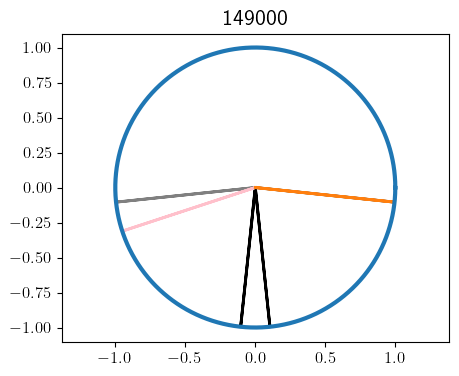

In [12]:
from IPython import display

for t in range(0, T, int(1e3)):
    plt.cla()  
#     plt.figure(figsize=(10,10))

    plt.xlim((-2, 2))
    plt.ylim((-1.0, 1.0))
    theta = np.arange(0, 2*np.pi, 0.01)
    x = np.cos(theta)
    y = np.sin(theta)
    plt.plot(x, y,color="C0")
    plt.axis('equal')
    plt.arrow(0, 0, x_po[0], x_po[1], color="black", linewidth=2)
    plt.arrow(0, 0, x_ne[0], x_ne[1], color="black", linewidth=2)
    plt.arrow(0, 0, x_po_perp[0], x_po_perp[1], color="gray", linewidth=2)
    plt.arrow(0, 0, x_ne_perp[0], x_ne_perp[1], color="gray", linewidth=2)

    plt.arrow(0, 0, fc1s[t][index_ne, 0]/np.sqrt(fc1s[t][index_ne, 0]**2 + fc1s[t][index_ne, 1]**2), 
              fc1s[t][index_ne, 1]/np.sqrt(fc1s[t][index_ne, 0]**2 + fc1s[t][index_ne, 1]**2), color="pink", linewidth=2)
#     plt.scatter(fc1s[t][index_ne, 0], fc1s[t][index_ne, 1], color="pink", linewidth=2)
    plt.arrow(0, 0, fc1s[t][index_po, 0]/np.sqrt(fc1s[t][index_po, 0]**2 + fc1s[t][index_po, 1]**2), 
              fc1s[t][index_po, 1]/np.sqrt(fc1s[t][index_po, 0]**2 + fc1s[t][index_po, 1]**2), color="C1", linewidth=2)
#     plt.scatter(fc1s[t][index_po, 0], fc1s[t][index_po, 1], color="C1", linewidth=2)
    
#     plt.arrow(0, 0, F_vec_po[t][0]/np.sqrt(F_vec_po[t][0]**2 +F_vec_po[t][1]**2), 
#               F_vec_po[t][1]/np.sqrt(F_vec_po[t][0]**2 +F_vec_po[t][1]**2), color="green", linewidth=1)
#     plt.scatter(F_vec_po[t][0], F_vec_po[t][1], color="green", linewidth=2)
#     plt.arrow(0, 0, F_vec_ne[t][0]/np.sqrt(F_vec_ne[t][0]**2 +F_vec_ne[t][1]**2), 
#               F_vec_ne[t][1]/np.sqrt(F_vec_ne[t][0]**2 +F_vec_ne[t][1]**2), color="green", linewidth=1)
    
    
    display.clear_output(wait=True)
    plt.title(t)
    plt.pause(0.00000001)


plt.show()


/Users/wangmingze/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


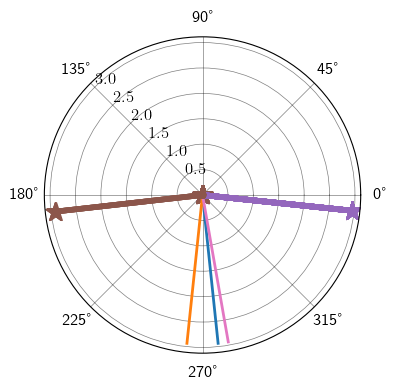

In [14]:
from matplotlib import rcParams
plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{amsmath}",
    "font.family": "sans-serif",
#     "font.serif": ["Calibri"abs],
    "grid.color": "0.5",    # gray gridlines
    "grid.linestyle": "-",  # solid gridlines
    "grid.linewidth": 0.5,  # thin gridlines
    "axes.titlesize" : 16,
    "axes.labelsize" : 12,
    "lines.linewidth" : 3,
    "lines.markersize" : 14,
    "xtick.labelsize" : 12,
    "ytick.labelsize" : 12,
    "figure.figsize" : (5, 4),
    "legend.fontsize" : 16,
    "legend.handlelength": 1,
#     "savefig.bbox": "tight",
#     "savefig.dpi": 300,
})
import matplotlib.pyplot as plt

ax = plt.gca(projection='polar')
ax.set_rlabel_position(135)  # 标签显示在0°
ax.grid(True, linestyle="-", color="k", linewidth=0.5, alpha=0.5)

t = 60000

R = 0.0

for i in range(int(width/2)):
    t_i = np.arctan2(fc1s[t][i, 1], fc1s[t][i, 0])
    r_i = np.sqrt(fc1s[t][i, 0]**2+fc1s[t][i, 1]**2)
    if R < r_i:
        R = r_i
    
for i in range(int(width/2)):
    t_i = np.arctan2(fc1s[t][i+int(width/2), 1], fc1s[t][i+int(width/2), 0])
    r_i = np.sqrt(fc1s[t][i+int(width/2), 0]**2+fc1s[t][i+int(width/2), 1]**2)
    if R < r_i:
        R = r_i
        
por = 1.0
cons = 0.99 * por
        
t_x_po = np.arctan2(x_po[1], x_po[0])
# plt.scatter(t_x_po, 1, marker='o', color='C0',label=r'$\boldsymbol{x}_+$')
plt.plot([0, t_x_po], [0, R*cons], color='C0', linewidth=2)

t_x_ne = np.arctan2(x_ne[1], x_ne[0])
# plt.scatter(t_x_ne, 1, marker='o', color='C1',label=r'$\boldsymbol{x}_-$')
plt.plot([0, t_x_ne], [0, R*cons], color='C1', linewidth=2)

t_x_po_perp = np.arctan2(x_po_perp[1], x_po_perp[0])
# plt.scatter(t_x_po_perp, 1, marker='o', color='C2',label=r'$\boldsymbol{x}_+^{\perp}$')
plt.plot([0, t_x_po_perp], [0, R*cons], color='C2', linewidth=2)

t_x_ne_perp = np.arctan2(x_ne_perp[1], x_ne_perp[0])
# plt.scatter(t_x_ne_perp, 1, marker='o', color='C3')
plt.plot([0, t_x_ne_perp], [0, R*cons], color='C3', linewidth=2)

t_mu = np.arctan2(mu[1], mu[0])
# plt.scatter(t_mu, 1, marker='o', color='C6',label=r'$\boldsymbol{\mu}$')
plt.plot([0, t_mu], [0, R*cons], color='C6', linewidth=2)
        
for i in range(int(width/2)):
    t_i = np.arctan2(fc1s[t][i, 1], fc1s[t][i, 0])
    r_i = np.sqrt(fc1s[t][i, 0]**2+fc1s[t][i, 1]**2) * por 
    plt.scatter(t_i, r_i, marker='*', color='C4')
    plt.plot([0, t_i], [0, r_i], color='C4', linewidth=4)

    
for i in range(int(width/2)):
    t_i = np.arctan2(fc1s[t][i+int(width/2), 1], fc1s[t][i+int(width/2), 0])
    r_i = np.sqrt(fc1s[t][i+int(width/2), 0]**2+fc1s[t][i+int(width/2), 1]**2) * por 
    plt.scatter(t_i, r_i, marker='*', color='C5')
    plt.plot([0, t_i], [0, r_i], color='C5', linewidth=4)
    
# ax.set_rlim(0.0, R+0.01)  # 标签范围


ax.set_axisbelow('True') 
# plt.legend(bbox_to_anchor=(0.73, 0.55))
plt.tight_layout()
# plt.title(r'$t=$%s' %t)
plt.tight_layout()
# plt.savefig("./figs/%s.pdf" %t, dpi=500)
# plt.savefig("./figs/%s.png" %t, dpi=500)